In [67]:
import pandas as pd
import matplotlib.pyplot as plt

In [68]:
from sklearn.base import BaseEstimator
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_percentage_error,
    r2_score,
)
from datetime import datetime
from sklearn.metrics import PredictionErrorDisplay


class MyModel(BaseEstimator):
    def __init__(self, estimator=None, scalerX=None, scalerY=None):
        self.estimator = estimator
        self.scalerX = scalerX
        self.scalerY = scalerY
        self.dt = datetime.now().strftime("%Y-%m-%d_%H-%M")

    def fit(self, X, Y):
        X_sc = self.scalerX.fit_transform(X)
        Y_sc = self.scalerY.fit_transform(Y)
        self.estimator.fit(X_sc, Y_sc)
        self.is_fitted = True
        return self

    def predict(self, X):
        X_sc = self.transform(X=X)
        return self.estimator.predict(X_sc)

    def transform(self, X, Y=None):
        if not self.is_fitted:
            raise Exception("Model is not fitted yet")
        X_sc = self.scalerX.transform(X)
        if Y is None:
            return X_sc
        Y_sc = self.scalerY.transform(Y)
        return X_sc, Y_sc

    @staticmethod
    def eval_perf(y_true, y_pred):
        mse = mean_squared_error(y_true=y_true, y_pred=y_pred)
        mape = mean_absolute_percentage_error(y_true=y_true, y_pred=y_pred)
        r2 = r2_score(y_true=y_true, y_pred=y_pred)
        return mse, mape, r2

    @staticmethod
    def print_perf(data):
        for k, v in data.items():
            print(k, ":", v)

    def eval(self, X_train, X_test, Y_train, Y_test, save=False):
        X_train, Y_train = self.transform(X_train, Y_train)
        X_test, Y_test = self.transform(X_test, Y_test)

        Y_train_pred = self.predict(X_train)
        Y_test_pred = self.predict(X_test)

        data_arr = []
        for i in range(0, Y_train.shape[1]):
            mse_train, mape_train, r2_train = self.eval_perf(
                y_true=Y_train[:, i], y_pred=Y_train_pred[:, i]
            )
            mse_test, mape_test, r2_test = self.eval_perf(
                y_true=Y_test[:, i], y_pred=Y_test_pred[:, i]
            )

            data = {
                "Y": f"Y-{i + 1}",
                "MSE Train": mse_train,
                "MSE Test": mse_test,
                "MAPE Train": mape_train,
                "MAPE Test": mape_test,
                "R2 Train": r2_train,
                "R2 Test": r2_test,
            }
            self.print_perf(data)
            data_arr.append(data)

        mse_train, mape_train, r2_train = self.eval_perf(y_true=Y_train, y_pred=Y_train_pred)
        mse_test, mape_test, r2_test = self.eval_perf(y_true=Y_test, y_pred=Y_test_pred)
        self.print_perf(data)
        data = {
            "Y": "Y-All",
            "MSE Train": mse_train,
            "MSE Test": mse_test,
            "MAPE Train": mape_train,
            "MAPE Test": mape_test,
            "R2 Train": r2_train,
            "R2 Test": r2_test,
        }
        df_eval = pd.DataFrame.from_dict(data_arr)
        if save:
            filename = f"eval_{self.dt}.xlsx"
            df_eval.to_excel(filename, index=False)
        return df_eval

    def plot_res(self, X_train, X_test, Y_train, Y_test, save=False):
        X_train, Y_train = self.transform(X_train, Y_train)
        X_test, Y_test = self.transform(X_test, Y_test)

        Y_train_pred = self.predict(X_train)
        Y_test_pred = self.predict(X_test)

        for i in range(0, Y_train.shape[1]):
            fig, axes = plt.subplots(
                nrows=1,
                ncols=2,
                figsize=(10, 5),
                constrained_layout=True,
                sharex=True,
                sharey=True,
            )

            display_train = PredictionErrorDisplay(
                y_true=Y_train[:, i], y_pred=Y_train_pred[:, i]
            )
            display_train.plot(ax=axes[0])
            axes[0].set_title("Train")

            display_train = PredictionErrorDisplay(
                y_true=Y_test[:, i], y_pred=Y_test_pred[:, i]
            )
            display_train.plot(ax=axes[1])
            axes[1].set_title("Test")

            filename = f"res_plot_{self.dt}_{i}.png"
            if save:
                fig.savefig(filename, dpi=300)
            plt.show()

### Read data

In [69]:
df = pd.read_excel("data.xlsx", index_col="exp")
df.head()

,m1,m2,m3,s1__autocorrelation__lag_8,s1__autocorrelation__lag_9,s1__autocorrelation__lag_7,s1__autocorrelation__lag_6,s1__autocorrelation__lag_5,s1__autocorrelation__lag_4,s1__longest_strike_above_mean,...,s1__ar_coefficient__coeff_3__k_10,s1__approximate_entropy__m_2__r_0.1,s1__lempel_ziv_complexity__bins_3,s1__partial_autocorrelation__lag_4,"s1__fft_coefficient__attr_""abs""__coeff_7","s1__agg_autocorrelation__f_agg_""var""__maxlag_40",s1__spkt_welch_density__coeff_2,y1,y2,y3
exp,,,,,,,,,,,,,,,,,,,,,
E001,150.223716,1176.177278,1.142097,-0.305434,-0.519191,-0.074829,0.159896,0.385790,0.590387,14,...,0.183996,0.158567,0.204152,-0.360084,0.293617,0.499488,5.886812e-08,55.460434,1.065917,114.578620
E002,102.534268,1483.654982,1.104716,-0.243785,-0.454262,-0.021002,0.202836,0.416423,0.608972,14,...,0.184370,0.144742,0.203008,-0.344364,6.142373,0.477743,3.643621e-06,50.640306,1.285666,124.651484
E003,119.890549,1254.897451,2.162773,-0.329006,-0.543405,-0.095913,0.142612,0.373002,0.582151,14,...,0.184036,0.144268,0.208163,-0.364611,26.783283,0.506435,1.590028e-04,50.832405,1.154859,57.018054
E004,162.830799,1302.043195,1.308283,-0.065152,-0.266498,0.138913,0.337187,0.521401,0.683873,16,...,0.187213,0.137326,0.193662,-0.355441,33.227591,0.460547,7.926165e-04,62.476545,1.025161,132.221218
E005,165.720956,1154.482314,1.566830,-0.304881,-0.518177,-0.074836,0.159321,0.384728,0.589003,14,...,0.183978,0.128546,0.192440,-0.357588,11.439470,0.497940,1.462831e-04,57.634438,1.043776,92.160269


In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100 entries, E001 to E100
Data columns (total 50 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   m1                                                  100 non-null    float64
 1   m2                                                  100 non-null    float64
 2   m3                                                  100 non-null    float64
 3   s1__autocorrelation__lag_8                          100 non-null    float64
 4   s1__autocorrelation__lag_9                          100 non-null    float64
 5   s1__autocorrelation__lag_7                          100 non-null    float64
 6   s1__autocorrelation__lag_6                          100 non-null    float64
 7   s1__autocorrelation__lag_5                          100 non-null    float64
 8   s1__autocorrelation__lag_4                          100 non-null    float64
 9   

### Extract data

In [71]:
_X = df.iloc[:, :-3]
_Y = df.iloc[:, -3:]
print(_X.shape)
print(_Y.shape)

(100, 47)
(100, 3)


### Split data

In [72]:
from sklearn.model_selection import train_test_split

_X_train, _X_test, _Y_train, _Y_test = train_test_split(
    _X, _Y, test_size=0.3, random_state=0
)
print(_X_train.shape)
print(_X_test.shape)
print(_Y_train.shape)
print(_Y_test.shape)

(70, 47)
(30, 47)
(70, 3)
(30, 3)


In [73]:
X_train = _X_train.values
Y_train = _Y_train.values
X_test = _X_test.values
Y_test = _Y_test.values

In [74]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
# from sklearn.svm import SVR
# from sklearn.multioutput import MultiOutputRegressor

reg = LinearRegression()

# reg = SVR() # Will give error
# reg = MultiOutputRegressor(estimator=SVR())
# reg = reg = MultiOutputRegressor(estimator=LinearRegression())

reg = MyModel(estimator=LinearRegression(), scalerX=StandardScaler(), scalerY=StandardScaler())

### Train Model

In [75]:
reg.fit(X_train, Y_train)

MyModel(estimator=LinearRegression(), scalerX=StandardScaler(),
        scalerY=StandardScaler())

### Predict results

In [76]:
Y_train_pred = reg.predict(X_train)
Y_test_pred = reg.predict(X_test)

print(Y_train_pred.shape)
print(Y_test_pred.shape)

(70, 3)
(30, 3)


### Evaluate model performance

In [77]:
reg.eval(X_train=X_train, X_test=X_test, Y_train=Y_train, Y_test=Y_test)

Y : Y-1
MSE Train : 3241931567304.9053
MSE Test : 4651291775903.416
MAPE Train : 4114826.548094277
MAPE Test : 4373372.8266763
R2 Train : -3241931567303.9053
R2 Test : -3889315869747.0864
Y : Y-2
MSE Train : 584760430605728.1
MSE Test : 829021572142523.6
MAPE Train : 51046679.02304706
MAPE Test : 68300781.26523492
R2 Train : -584760430605727.1
R2 Test : -1029822415070684.2
Y : Y-3
MSE Train : 2111687620086.6785
MSE Test : 3029698406264.986
MAPE Train : 6442229.49908111
MAPE Test : 6020986.896419811
R2 Train : -2111687620085.6782
R2 Test : -3398767071182.8486
Y : Y-3
MSE Train : 2111687620086.6785
MSE Test : 3029698406264.986
MAPE Train : 6442229.49908111
MAPE Test : 6020986.896419811
R2 Train : -2111687620085.6782
R2 Test : -3398767071182.8486


,Y,MSE Train,MSE Test,MAPE Train,MAPE Test,R2 Train,R2 Test
0,Y-1,3.241932e+12,4.651292e+12,4.114827e+06,4.373373e+06,-3.241932e+12,-3.889316e+12
1,Y-2,5.847604e+14,8.290216e+14,5.104668e+07,6.830078e+07,-5.847604e+14,-1.029822e+15
2,Y-3,2.111688e+12,3.029698e+12,6.442229e+06,6.020987e+06,-2.111688e+12,-3.398767e+12


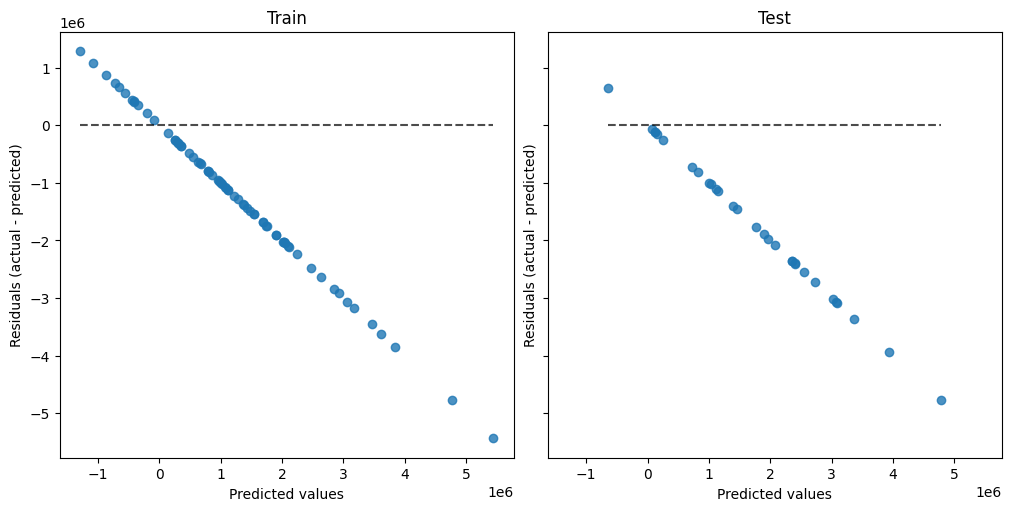

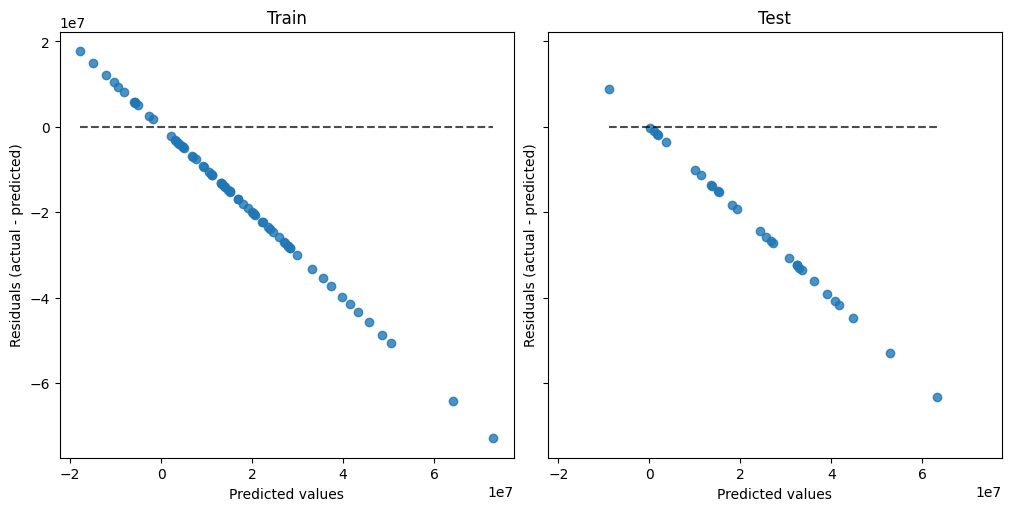

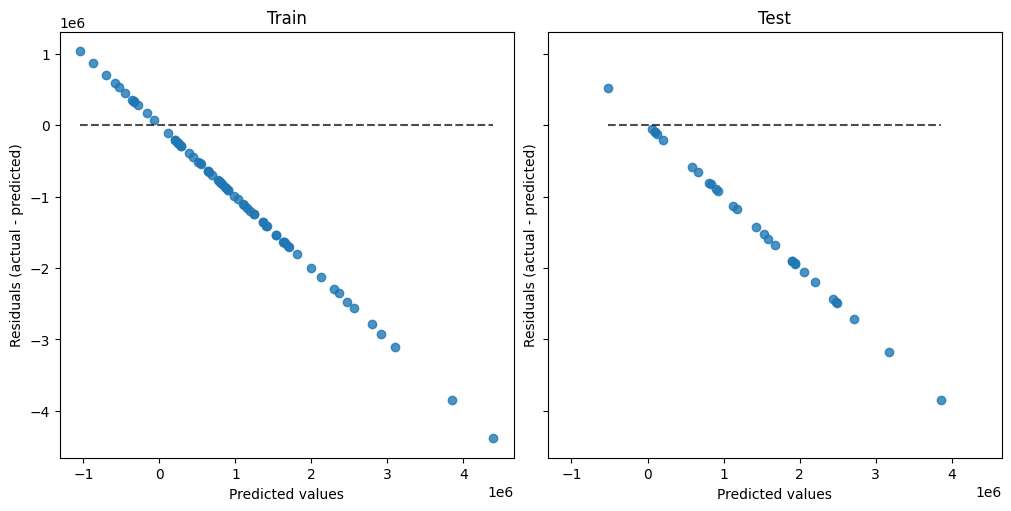

In [78]:
reg.plot_res(X_train=X_train, X_test=X_test, Y_train=Y_train, Y_test=Y_test)

### Save data

In [79]:
import pickle

filename = f"data_{dt}.pkl"

data_save = {
    "model": reg,
    "desc": "This is the saved data",
    "Y_train": Y_train,
    "Y_train_pred": Y_train_pred,
    "Y_test": Y_test,
    "Y_test_Pred": Y_test_pred,
    "eval": df_eval,
}

# Save the model
with open(filename, "wb") as file:
    pickle.dump(data_save, file)

NameError: name 'dt' is not defined

### Test loading data

In [ ]:
with open(filename, "rb") as file:
    data_load = pickle.load(file)

print(data_load)